In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [2]:
from PAN import *
from DSS_analyzer_Mariner import Data1D_GAUGE, Data3D_geometry

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
dx = 1
nx = 1001
x = np.arange(0, nx * dx, dx)

In [5]:
# Design grid in time
# 1000 time steps
dt = 1
nt = 1001
t = np.arange(0, nt * dt, dt)

In [6]:
# set injection profile: 
inj_location = np.array([250, 500, 750])
inj_time = np.array([250, 500, 750])
# set injection time: 
inj_duration = 125

In [7]:
# design perm (D) array
diffusivity = 400
d = np.ones_like(x) * diffusivity

In [8]:
# sort the inj_location from small to large:
inj_location = np.sort(inj_location)
inj_time = np.sort(inj_time)

In [9]:
inj_tmp = inj_time + inj_duration

ind = np.full_like(t, False, dtype=bool)
for iter in range(len(inj_time)):
    ind = ind | (t > inj_time[iter]) & (t < inj_tmp[iter])

In [10]:
# set up initial condition
U = np.zeros_like(x)
U_snapshot = np.zeros((nx, nt))

In [11]:
from tqdm import tqdm

In [12]:
stage_num_all = []

In [13]:
for iter in tqdm(range(len(t))):
    # Do the simulation. 
    alpha = d * dt / dx**2
    
    # Form the matrix normally. 
    A = np.zeros((nx, nx))
    R = np.zeros(nx)
    
    # Fill the main diagonal of A matrix using numpy
    np.fill_diagonal(A, 1 + 2 * alpha)
    
    # Fill the upper diagonal of A matrix using numpy    
    np.fill_diagonal(A[:, 1:], - alpha)
    
    # Fill the lower diagonal of A matrix using numpy
    np.fill_diagonal(A[1:, :], - alpha)
    
    # generate R 
    R = U
    
    # Implement the boundary condition
    A[0][0] = 1
    A[0][1] = -1 # Neumann BC
    
    A[-1][-1] = -1
    A[-1][-2] = 1 # Neumann BC
    
    R[0] = 0
    R[-1] = 0

    # Apply exponential decay for past stages even when not injecting
    stage_num = np.where(iter > inj_time)[0][-1] if ind[iter] else -1
    for past_stage in range(stage_num + 1):
        past_inj_loc = np.array([inj_location[past_stage] - 3, inj_location[past_stage] + 3])
        past_inj_ind = [np.argmin(np.abs(x - past_inj_loc[i])) for i in range(len(past_inj_loc))]
        decay_factor = 0.9
        R[past_inj_ind[0]:past_inj_ind[1]] *= decay_factor
        
        # Apply boundary condition for past stages
        for val in range(past_inj_ind[0], past_inj_ind[1]):
            A[val, :] = 0
            A[val, val] = 1
            # R[val] = 0

    if ind[iter]:
        # use the stage_num to determine the injection location, then change the A and R matrix.
        inj_loc = np.array([inj_location[stage_num] - 3, inj_location[stage_num] + 3])
        # find the index of the injection location
        inj_ind = [np.argmin(np.abs(x - inj_loc[i])) for i in range(len(inj_loc))]
        
        # change R matrix to implement the injection. Change the value.
        R[inj_ind[0]:inj_ind[1]] = 2000
        
        # change the A matrix to implement the injection. Change the value to 0.
        for val in range(inj_ind[0], inj_ind[1]):
            A[val, :] = 0
            A[val, val] = 1

    # Solve the linear system
    U = np.linalg.solve(A, R)
    U_snapshot[:, iter] = U
    
    # update the diffusion coefficient after the injection. if the iter is one of the element in inj_time, then update the diffusion coefficient.
    if iter in inj_tmp - 1: 
        # update the diffusion coefficient at the injection location.
        d[inj_ind[0]-2:inj_ind[1]+2] = d[inj_ind[0]-2:inj_ind[1]+2] * 0.8

100%|██████████| 1001/1001 [00:38<00:00, 26.12it/s]


In [14]:
U_snapshot += 8700

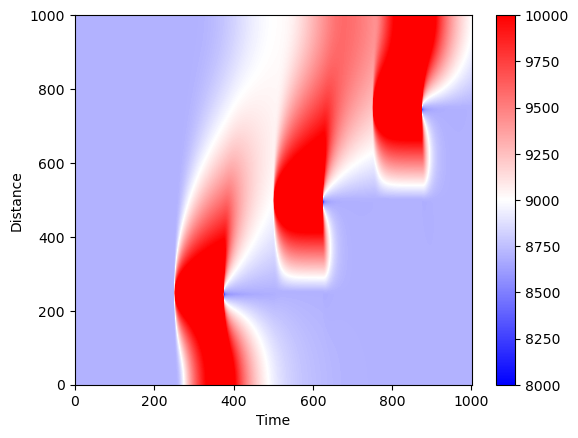

In [15]:
# imshow
# extent = [0, nt, 0, nx]
plt.figure()
plt.imshow(U_snapshot, aspect='auto', cmap='bwr')
plt.clim([8000, 10000])
plt.xlabel('Time')
plt.ylabel('Distance')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

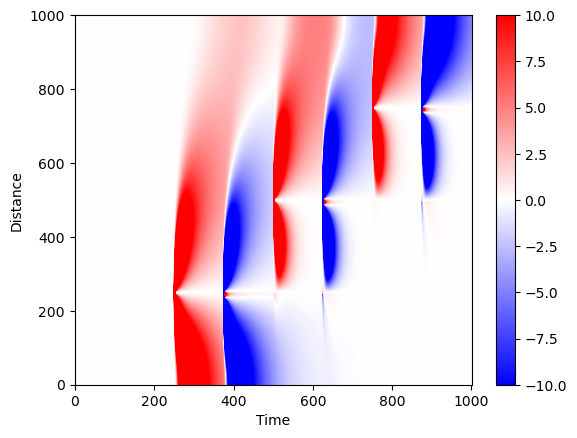

In [16]:
# Do a gradient to simulate the strain rate
strain_rate = np.gradient(U_snapshot, axis=1)

plt.figure()
plt.imshow(strain_rate, aspect='auto', cmap='bwr')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.clim([-10, 10])
plt.colorbar()
# invert the y-axis
plt.gca().invert_yaxis()
plt.show()

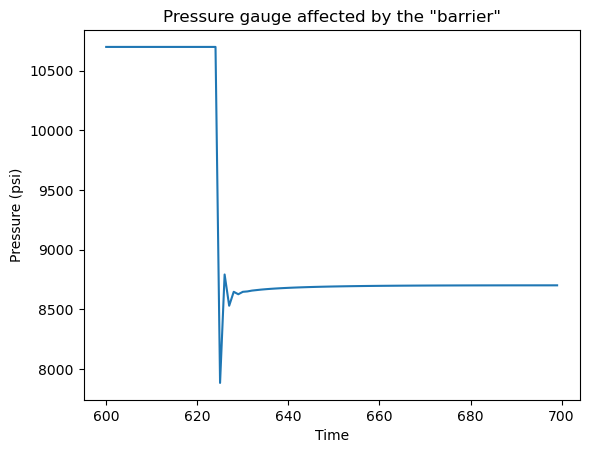

In [17]:
plt.figure()
plt.plot(t[600:700], U_snapshot[500, 600:700])
plt.xlabel('Time')
plt.ylabel('Pressure (psi)')
plt.title('Pressure gauge affected by the "barrier"')
plt.show()

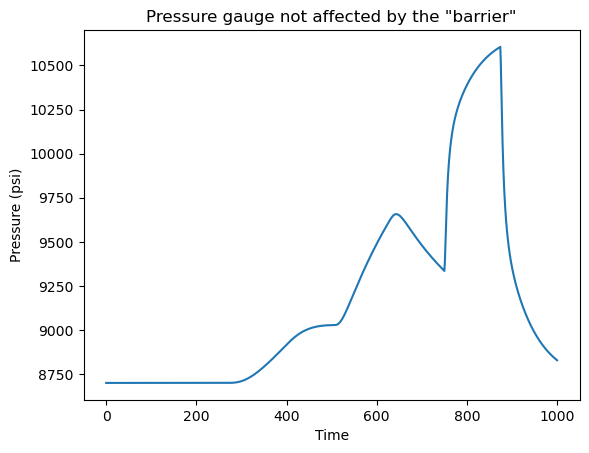

In [18]:
plt.show()
plt.figure()
plt.plot(t, U_snapshot[820, :])
plt.xlabel('Time')
plt.ylabel('Pressure (psi)')
plt.title('Pressure gauge not affected by the "barrier"')
plt.show()

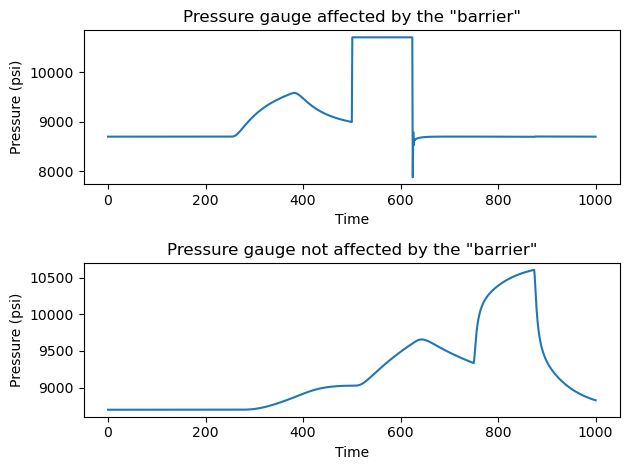

In [19]:
# subplot the two figures above
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, U_snapshot[500, :])
plt.xlabel('Time')
plt.ylabel('Pressure (psi)')
plt.title('Pressure gauge affected by the "barrier"')

plt.subplot(2, 1, 2)
plt.plot(t, U_snapshot[820, :])
plt.xlabel('Time')
plt.ylabel('Pressure (psi)')
plt.title('Pressure gauge not affected by the "barrier"')

plt.tight_layout()
plt.show()

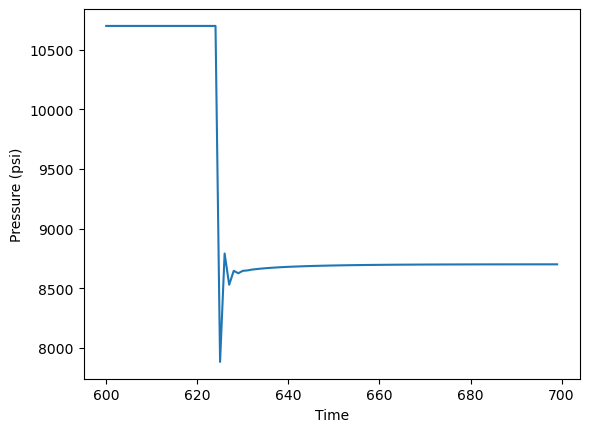

In [20]:
# plot the second time step
plt.figure()
plt.plot(x[600:700], U_snapshot[500, 600:700])
plt.xlabel('Time')
plt.ylabel('Pressure (psi)')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1001,) and (0,)

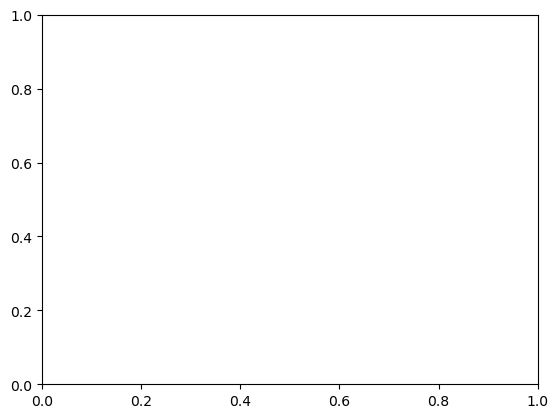

In [21]:
plt.figure()
plt.plot(t, stage_num_all)
plt.xlabel('Time')
plt.ylabel('Stage Number')
plt.show()